In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2020,1,1)
end  = datetime.now()
current_date = datetime.now()

In [3]:
market = Market()

In [4]:
pricer_classes = [] 
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)
pricer_classes.append(Pricer.MONTHLY_STOCK_ROLLING)
pricer_classes.append(Pricer.MONTHLY_STOCK_WINDOW)

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [7]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    trade_algo.pull_optimal_parameter()
    parameter = trade_algo.parameter
    try:
        trade = trade_algo.pull_performance()
        if trade.index.size > 0:
            positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
            pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
            trade = trade[trade["position"] <= positions]
            ledger = trade.sort_values(["year",pricer_timeframe]).copy()
            ledger= ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
            anas = trade_algo.analysis
            if ledger.index.size > 0:
                cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                for key in parameter.keys():
                    cumulative[key] = parameter[key]
                cumulative["trade_algo"] = trade_algo.name
                for key in parameter.keys():
                    cumulative[key] = parameter[key]
                analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.95s/it]


In [8]:
trade

,year,month,ticker,monthly_delta,monthly_delta_sign,actual_returns,position,iteration
0,2001,1,ABMD,0.708614,1.0,1.535808,0,2
1,2001,2,ADBE,1.110529,1.0,0.957956,0,2
2,2001,3,ADBE,1.051357,1.0,1.400669,0,2
3,2001,4,ADBE,0.302558,1.0,0.942649,0,2
4,2001,5,ABMD,0.353387,1.0,1.191919,0,2
...,...,...,...,...,...,...,...,...
837,2004,8,AOS,0.009130,1.0,0.852356,12,2
838,2015,9,ACN,0.027214,1.0,1.064687,12,2
839,2004,8,MMM,0.004719,1.0,0.997596,13,2
840,2015,9,ADBE,0.022019,1.0,1.081984,13,2


In [9]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
16,True,False,False,False,rrr,1,tyield1,1,1,dsb_n_n_b_r,98.381952,-0.075084,0.961924,-1296.966527
14,True,False,False,False,none,1,tyield1,1,2,dsdr_n_n_b_r,23.821644,-0.064586,0.967357,-353.350105
17,True,False,False,False,none,1,tyield1,1,2,dsb_n_n_b_r,13.679300,-0.055456,0.971983,-228.635638
11,True,False,False,False,none,1,tyield1,1,2,dsw_n_n_b_r,9.301059,-0.059337,0.971159,-139.895259
7,True,False,False,False,rrr,1,tyield1,1,1,dsr_n_n_b_r,5.651370,-0.069138,0.967288,-67.275280
13,True,False,False,False,rrr,1,tyield1,1,1,dsdr_n_n_b_r,5.326762,-0.055500,0.971841,-77.958672
5,True,False,False,False,none,1,tyield1,1,2,wsw_n_n_b_r,5.223930,-0.177307,0.913364,-23.819298
15,True,False,False,False,flat,1,tyield1,1,0,dsb_n_n_b_r,5.050350,-0.061429,0.972232,-65.934141
8,True,False,False,False,none,1,tyield1,1,2,dsr_n_n_b_r,4.620670,-0.052791,0.974415,-68.582691
10,True,False,False,False,rrr,1,tyield1,1,1,dsw_n_n_b_r,4.124796,-0.063674,0.969591,-49.073782


In [10]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
0,dsb_n_n_b_r,True,False,False,False,rrr,1,tyield1,1,1,98.381952,-0.075084,0.961924,-1296.966527
1,dsdr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,23.821644,-0.064586,0.967357,-353.350105
3,dsw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,9.301059,-0.059337,0.971159,-139.895259
2,dsr_n_n_b_r,True,False,False,False,rrr,1,tyield1,1,1,5.651370,-0.069138,0.967288,-67.275280
7,wsw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,5.223930,-0.177307,0.913364,-23.819298
6,wsr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,3.548310,-0.194950,0.910817,-13.068492
5,msw_n_n_b_r,True,False,False,False,rrr,1,tyield1,1,1,3.417256,0.342752,1.151528,7.044777
4,msr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,2.855452,0.005231,1.003674,354.204700


In [11]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [12]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [13]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year) & (ledger["year"]<end.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [14]:
positions

20

In [15]:
ledger["position"].max()

9

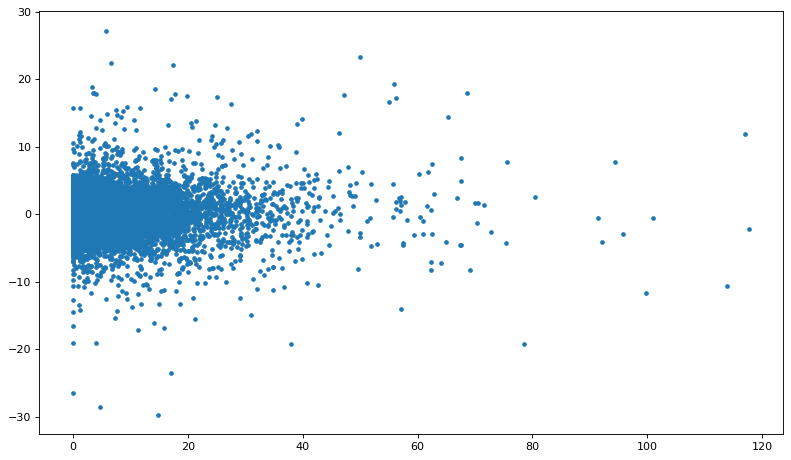

In [16]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [17]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,ABMD,0.146804,1.0,1.094667,0,Health Care,Abiomed
4513,2001,2001-01-02,ABT,0.116020,1.0,0.977769,1,Health Care,Abbott
8625,2001,2001-01-02,ATVI,0.000000,1.0,1.075714,2,Communication Services,Activision Blizzard
1,2001,2001-01-03,ADBE,0.640691,1.0,0.927684,0,Information Technology,Adobe Inc.
4514,2001,2001-01-03,ABMD,0.236000,1.0,0.918798,1,Health Care,Abiomed
8626,2001,2001-01-03,ABT,0.116767,1.0,0.908415,2,Health Care,Abbott
12124,2001,2001-01-03,ATVI,0.080714,1.0,1.091633,3,Communication Services,Activision Blizzard
14873,2001,2001-01-03,ADP,0.064871,1.0,0.933169,4,Information Technology,ADP
16896,2001,2001-01-03,ADM,0.025290,1.0,1.004286,5,Consumer Staples,ADM
2,2001,2001-01-04,ADBE,0.279085,1.0,0.958140,0,Information Technology,Adobe Inc.


In [18]:
ledger.sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
656,2003,2003-09-24,ABMD,0.057353,1.0,1.271930,0,Health Care,Abiomed
6251,2008,2008-10-10,ATVI,0.499567,1.0,1.232699,1,Communication Services,Activision Blizzard
10652,2011,2011-11-02,ABMD,0.066294,1.0,1.224673,2,Health Care,Abiomed
557,2003,2003-04-28,ABMD,0.174699,1.0,1.220820,0,Health Care,Abiomed
1895,2008,2008-10-29,ABMD,0.558719,1.0,1.192876,0,Health Care,Abiomed
11536,2017,2017-02-09,ATVI,0.032661,1.0,1.188774,2,Communication Services,Activision Blizzard
441,2002,2002-10-22,ABMD,0.142817,1.0,1.184874,0,Health Care,Abiomed
5,2001,2001-01-09,ABMD,0.685455,1.0,1.180258,0,Health Care,Abiomed
3370,2015,2015-03-23,ABMD,0.036500,1.0,1.179880,0,Health Care,Abiomed
18294,2002,2002-06-27,ABMD,0.034965,1.0,1.179277,6,Health Care,Abiomed


In [19]:
ledger["actual_returns"].mean()

1.0007113197155717

In [20]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.518172740888667

In [21]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [22]:
portfolio.head(20)

position,year,date,0,1,2,3,4,5,6,7,8,9
0,2001,2001-01-02,1.094667,0.977769,1.075714,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
1,2001,2001-01-03,0.927684,0.918798,0.908415,1.091633,0.933169,1.004286,1.000000,1.0,1.0,1.0
2,2001,2001-01-04,0.958140,0.894830,1.005848,0.992092,0.968072,0.982219,0.963025,1.0,1.0,1.0
3,2001,2001-01-05,0.962330,1.063722,0.996321,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
4,2001,2001-01-08,1.005044,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0
5,2001,2001-01-09,1.180258,0.918490,1.000000,1.076923,1.000000,1.000000,1.000000,1.0,1.0,1.0
6,2001,2001-01-10,1.016104,1.050492,1.000000,0.978897,1.000000,1.000000,1.000000,1.0,1.0,1.0
7,2001,2001-01-11,1.049521,0.978591,0.995132,1.025143,1.000000,1.000000,1.000000,1.0,1.0,1.0
8,2001,2001-01-12,1.008723,1.034640,1.030748,0.996098,1.000000,1.000000,1.000000,1.0,1.0,1.0
9,2001,2001-01-16,1.051494,0.969163,1.004068,1.031897,1.000000,1.000000,1.000000,1.0,1.0,1.0


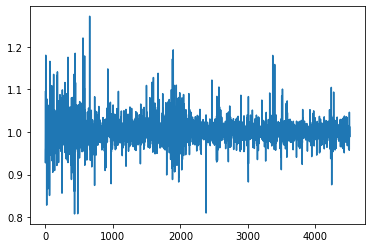

In [23]:
plt.plot(portfolio[0])

In [26]:
positions = ledger["position"].max()

In [27]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [28]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,year,date,week,pv,daily_returns,adjclose,bench
21925,1923.029907,1.712357,3.737011,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-30,1,214.984878,1.000373,6665.938,2.908528
21926,1923.029907,1.712357,3.737011,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-30,1,214.984878,1.000373,6463.504,2.820200
21927,1923.029907,1.712357,3.737011,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-30,1,214.984878,1.000373,6738.855,2.940343
21928,1923.029907,1.712357,3.737011,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-30,1,214.984878,1.000373,8945.992,3.903376
21929,1923.029907,1.712357,3.737011,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-30,1,214.984878,1.000373,8972.605,3.914988
21930,1944.966435,1.747105,3.717661,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-31,1,217.423981,1.002947,6665.938,2.908528
21931,1944.966435,1.747105,3.717661,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-31,1,217.423981,1.002947,6463.504,2.820200
21932,1944.966435,1.747105,3.717661,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-31,1,217.423981,1.002947,6738.855,2.940343
21933,1944.966435,1.747105,3.717661,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-31,1,217.423981,1.002947,8945.992,3.903376
21934,1944.966435,1.747105,3.717661,0.582255,2.053942,0.513236,1.115101,1.436158,0.683936,2019,2019-12-31,1,217.423981,1.002947,8972.605,3.914988


In [29]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [30]:
cash_analysis["cash"].sum()

5936.137982038509

In [31]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.016461,NaN,NaN,0.000000,0.000000
1,1.016461,1.0,1.016461,1.646106,1.646106
2,1.016461,1.0,1.016461,1.646106,3.292211
3,1.016461,1.0,1.016461,1.646106,4.938317
4,1.016461,1.0,1.016461,1.646106,6.584422
...,...,...,...,...,...
21930,1.002947,1.0,1.002947,0.294686,5934.959237
21931,1.002947,1.0,1.002947,0.294686,5935.253923
21932,1.002947,1.0,1.002947,0.294686,5935.548610
21933,1.002947,1.0,1.002947,0.294686,5935.843296


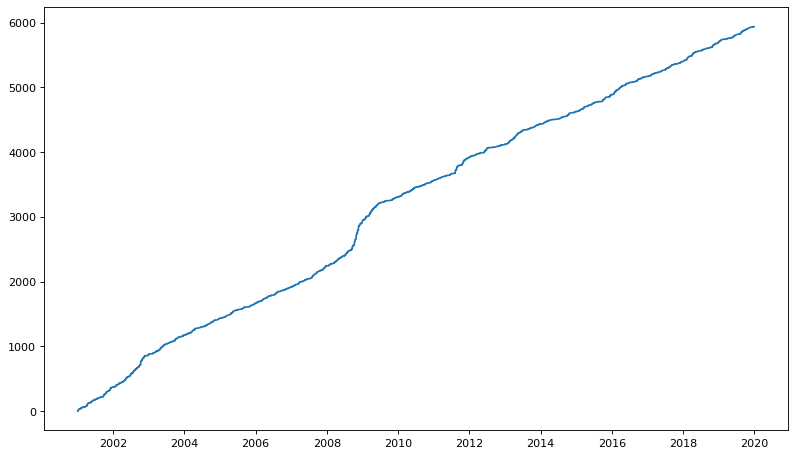

In [32]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

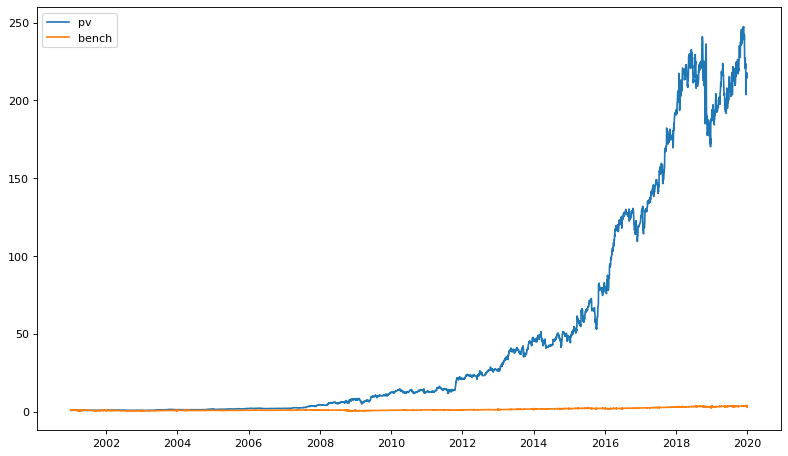

In [33]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [34]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,year,date,week,pv,daily_returns,adjclose,bench
0,1.094667,0.977769,1.075714,1.000000,1.000000,1.000000,1.000000,1.0,1.0,2001,2001-01-02,1,1.016461,1.016461,2291.86,1.000000
1,1.094667,0.977769,1.075714,1.000000,1.000000,1.000000,1.000000,1.0,1.0,2001,2001-01-02,1,1.016461,1.016461,2616.69,1.141732
2,1.094667,0.977769,1.075714,1.000000,1.000000,1.000000,1.000000,1.0,1.0,2001,2001-01-02,1,1.016461,1.016461,2566.83,1.119977
3,1.094667,0.977769,1.075714,1.000000,1.000000,1.000000,1.000000,1.0,1.0,2001,2001-01-02,1,1.016461,1.016461,2407.65,1.050522
4,1.094667,0.977769,1.075714,1.000000,1.000000,1.000000,1.000000,1.0,1.0,2001,2001-01-02,1,1.016461,1.016461,1950.40,0.851012
5,1.015505,0.898372,0.977195,1.091633,0.933169,1.004286,1.000000,1.0,1.0,2001,2001-01-03,1,0.991129,0.975998,2291.86,1.000000
6,1.015505,0.898372,0.977195,1.091633,0.933169,1.004286,1.000000,1.0,1.0,2001,2001-01-03,1,0.991129,0.975998,2616.69,1.141732
7,1.015505,0.898372,0.977195,1.091633,0.933169,1.004286,1.000000,1.0,1.0,2001,2001-01-03,1,0.991129,0.975998,2566.83,1.119977
8,1.015505,0.898372,0.977195,1.091633,0.933169,1.004286,1.000000,1.0,1.0,2001,2001-01-03,1,0.991129,0.975998,2407.65,1.050522
9,1.015505,0.898372,0.977195,1.091633,0.933169,1.004286,1.000000,1.0,1.0,2001,2001-01-03,1,0.991129,0.975998,1950.40,0.851012


In [35]:
# plt.figure(figsize=(12, 7), dpi=80)
# position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
# for i in position_columns:
#     position = cumulative[i]
#     plt.plot(cumulative["date"],position)
# plt.show()


In [36]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Communication Services,2010.533242,0.062746,1.0,1.001310,1.786885
Consumer Staples,2009.732889,0.050004,1.0,1.000807,2.182667
Industrials,2010.330597,0.043521,1.0,1.000801,2.491294
Health Care,2010.838797,0.065990,1.0,1.000795,2.077595
Information Technology,2010.080512,0.046035,1.0,1.000349,2.578561


In [37]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

,,,,dately_delta,dately_delta_sign,actual_returns,position
year,date,ticker,Security,,,,
2003,2003-09-24,ABMD,Abiomed,0.057353,1.0,1.271930,0
2008,2008-10-10,ATVI,Activision Blizzard,0.499567,1.0,1.232699,1
2011,2011-11-02,ABMD,Abiomed,0.066294,1.0,1.224673,2
2003,2003-04-28,ABMD,Abiomed,0.174699,1.0,1.220820,0
2008,2008-10-29,ABMD,Abiomed,0.558719,1.0,1.192876,0
2017,2017-02-09,ATVI,Activision Blizzard,0.032661,1.0,1.188774,2
2002,2002-10-22,ABMD,Abiomed,0.142817,1.0,1.184874,0
2001,2001-01-09,ABMD,Abiomed,0.685455,1.0,1.180258,0
2015,2015-03-23,ABMD,Abiomed,0.036500,1.0,1.179880,0


In [38]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Staples,Health Care,Industrials,Information Technology
0,2001,2001-01-02 00:00:00.000000000,1.075714,1.000000,1.036218,1.000000,1.000000
1,4004001,2252-06-29 23:17:13.297436672,1.174286,1.004286,0.946695,1.000000,0.930426
2,8012006001,2159-09-27 04:21:44.589074432,1.165000,0.986429,0.899681,0.963025,0.896099
3,16032024008001,1970-01-01 00:00:00.000000000,1.160714,1.049286,0.899681,0.963025,0.862343
4,32080080040010001,1970-01-01 00:00:00.000000000,1.160714,1.049286,0.899681,0.963025,0.866693
...,...,...,...,...,...,...,...
4508,0,1970-01-01 00:00:00.000000000,8.583104,3.719370,11.815306,7.379755,2.679189
4509,0,1970-01-01 00:00:00.000000000,8.583104,3.727421,11.732442,7.407754,2.679189
4510,0,1970-01-01 00:00:00.000000000,8.583104,3.712930,11.619103,7.347994,2.679189
4511,0,1970-01-01 00:00:00.000000000,8.583104,3.712930,11.619103,7.372651,2.679189
